# Identification of human sequences

We'll try to replicate the [Classifying human DNA sequence and random ATCG sequences, using keras CNN](https://github.com/onceupon/deep_learning_DNA) problem, but using PyTorch instead.

In [1]:
import torch
import torch.utils.data as data_utils
from torch import nn
import pandas as pd
from numpy import argmax
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from numpy import vstack
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix
import os
import src.encoding as enc

In [2]:
dataset = pd.read_csv("datasets/human-exercise.csv")
print(dataset.shape)
dataset

(20000, 2)


,sequence,label
0,CTACTCGGGAGGCTGAGGCAGGAGAATCACTTGAACCAGGGAGTCA...,1
1,CACCTTATCCAGAGAAGCTTCTTCTTTTAGAAAATCAAGCAAAACA...,1
2,AAAGGGGCTGATAGAAAAATAAAGAGATTTGGCCAGGTACGGTGGC...,1
3,AAGTGGATATTCAGACCTCCTTGAGGCCTTCGTTGGAAACGGGATT...,1
4,ATACCATGACAAAGATATTATTAGCCAATTTTTAGAGAGAAGGAAA...,1
...,...,...
19995,AAGACGAGTGGTTACCCCCTGTGAGACTGCCGCGCGTGGTGGTCGG...,0
19996,ACGAGGCCATCTAGAGCGCAACGAAACTGCAAGAAAATACGTCCGA...,0
19997,CATCTTTACCCAATTTGTGTGTGGAAAGGTGTCAGCGATGCTTTGG...,0
19998,ATAAGTAACTCCAGTCGAGCGGAAGGTATAGTGGCACGGGGTTTAG...,0


As we can see, this dataset contains the sequence and the corresponding positive/negative class labels, with positive class labels corresponding to the human DNA. The amount of positive and negative examples is evenly distributed across the two classes.

1    10000
0    10000
Name: label, dtype: int64


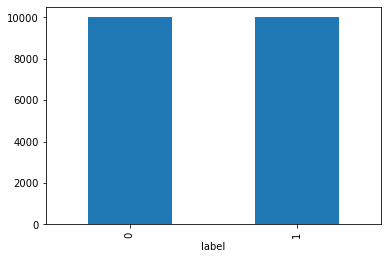

In [3]:
# plot the distribution of each class
dataset.groupby('label').size().plot(kind='bar')

print(dataset['label'].value_counts())

We need now to split the dataset into training, test and validation sets.

In [4]:
fps_x = dataset['sequence'].values
fps_y = dataset['label'].values

x, x_test, y, y_test = train_test_split(
    fps_x, fps_y,
    test_size=0.2,
    train_size=0.8,
    stratify=fps_y
)
x_train, x_cv, y_train, y_cv = train_test_split(
    x, y,
    test_size=0.25,
    train_size=0.75,
    stratify=y
)

Now we need to one hot encode the sequences.

In [5]:
x_train_enc = enc.DNAEncoding(x_train)
x_train = x_train_enc.one_hot_encode()

x_test_enc = enc.DNAEncoding(x_test)
x_test = x_test_enc.one_hot_encode()

x_cv_enc = enc.DNAEncoding(x_cv)
x_cv = x_cv_enc.one_hot_encode()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_cv.shape)
print(y_cv.shape)


(12000, 250, 4)
(12000,)
(4000, 250, 4)
(4000,)
(4000, 250, 4)
(4000,)


In [6]:
# convert to torch.tensor
train_data = data_utils.TensorDataset(
    torch.tensor(x_train, dtype=torch.float),
    torch.tensor(y_train, dtype=torch.long)
)
test_data = data_utils.TensorDataset(
    torch.tensor(x_test, dtype=torch.float),
    torch.tensor(y_test, dtype=torch.long)
)
valid_data = data_utils.TensorDataset(
    torch.tensor(x_cv, dtype=torch.float),
    torch.tensor(y_cv, dtype=torch.long)
)

batch_size = 16

# Data loader
trainloader = data_utils.DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size
)
testloader = data_utils.DataLoader(
    test_data,
    shuffle=True,
    batch_size=batch_size
)
validloader = data_utils.DataLoader(
    valid_data,
    shuffle=True,
    batch_size=batch_size
)

Building the model equivalent to the one in the paper.

In [7]:
from src.models import Net
from src.train import traindata
from src.test import test

In [8]:
torch.manual_seed(2022)
os.environ["CUDA_VISIBLE_DEVICES"] = '4,5'
device = torch.device('cuda:0')

epochs = 100
lr = 0.004
loss_function = nn.CrossEntropyLoss()
model = Net().to(device)
optimizer = Adam(model.parameters(), lr=lr)

model = traindata(device, model, epochs, optimizer, loss_function, trainloader, validloader)

# Test
acc, mcc, report = test(device, model, testloader)
print('Accuracy: %.3f' % acc)
print('MCC: %.3f' % mcc)
print(report)

[1/100, 0/750] loss: 0.71868831
[1/100, 100/750] loss: 0.50178188
[1/100, 200/750] loss: 0.43479669
[1/100, 300/750] loss: 0.44566453
[1/100, 400/750] loss: 0.49917829
[1/100, 500/750] loss: 0.46849173
[1/100, 600/750] loss: 0.34305367
[1/100, 700/750] loss: 0.37496141
The Current Loss: 0.334246883392334
trigger times: 0
[2/100, 0/750] loss: 0.33523715
[2/100, 100/750] loss: 0.43114179
[2/100, 200/750] loss: 0.39242992
[2/100, 300/750] loss: 0.33393493
[2/100, 400/750] loss: 0.46728218
[2/100, 500/750] loss: 0.32058808
[2/100, 600/750] loss: 0.38262829
[2/100, 700/750] loss: 0.38405123
The Current Loss: 0.3300363482236862
trigger times: 0
[3/100, 0/750] loss: 0.38001817
[3/100, 100/750] loss: 0.37495339
[3/100, 200/750] loss: 0.32003227
[3/100, 300/750] loss: 0.37921616
[3/100, 400/750] loss: 0.31660518
[3/100, 500/750] loss: 0.3182072
[3/100, 600/750] loss: 0.31512943
[3/100, 700/750] loss: 0.31866622
The Current Loss: 0.33059286236763
Trigger Times: 1
[4/100, 0/750] loss: 0.31560251
